# Data Anonymization via PredictiveGrid

In [1]:
import pandas as pd
import btrdb

from btrdb.utils.timez import *
from datetime import datetime, timedelta

In [2]:
db = btrdb.connect('api.ni4ai.org:4411', apikey='API_KEY')

# Select streams from the database

This demo will use real-time data streaming from a sensor in my home.

Here's a "permalink" to visualize data in The Plotter, our data visualization interface.

https://plot.ni4ai.org/permalink/v3iP--iLU

In [3]:
voltage = db.stream_from_uuid("cf0462cf-1c19-595b-96e4-169edc4a7448")

In [4]:
print('Collection Name\n===============')
voltage.collection

Collection Name


'ni4ai/oakland'

In [5]:
print('Sensor Metadata\n===============')
voltage.annotations()


Sensor Metadata


({'STN': 'Laurel_UPMU',
  'longitude': -122.211962,
  'ID_1': 0,
  'hardware': 'microPMU',
  'latitude': 37.842514,
  'location': 'Oakland, CA',
  'nominal_volts': 120,
  'sample_rate': '60Hz',
  'interconnect': 'WECC',
  'original_uuid': 'cf0462cf-1c19-595b-96e4-169edc4a7448',
  'ID_2': 0,
  'siting': 'wall outlet'},
 7)

# Querying recent measurements

In [6]:
point, version = voltage.current()

In [7]:
print('Latest Measurement Values\n=========================')
print('Voltage: \t %.2f'%(point.value))
print('Time (ns): \t %i'%(point.time))

# convert nanoseconds to datetime
tstamp = ns_to_datetime(point.time)
print('Time (date): \t %s'%str(tstamp.strftime('%Y-%m-%d %H:%M:%S')))

# how much time has passed since measurement
dt = currently_as_ns()-point.time
print('Time (delta): \t %s'%(timedelta(seconds=dt/1e9)))

Latest Measurement Values
Voltage: 	 123.30
Time (ns): 	 1618508824991662700
Time (date): 	 2021-04-15 17:47:04
Time (delta): 	 0:00:01.799706


# Querying statistical aggregates

In [8]:
%%time

pw = 36 # 2**36 nanoseconds, or about 1 min

start, _ = voltage.earliest()
end, _ = voltage.latest()

points, _ = zip(*voltage.aligned_windows(start.time, end.time, pw))

print('time history: \t %i days'%((ns_to_datetime(end.time)-ns_to_datetime(start.time)).days))
print('window: \t %i seconds'%(2**pw/1e9))
print('start time:', '\t', ns_to_datetime(start.time))
print('end time:', '\t', ns_to_datetime(end.time))
print()

time history: 	 27 days
window: 	 68 seconds
start time: 	 2021-03-19 17:03:28.008333+00:00
end time: 	 2021-04-15 17:47:04.991663+00:00

CPU times: user 208 ms, sys: 20.3 ms, total: 228 ms
Wall time: 922 ms


In [9]:
points[0]

StatPoint(1616173378618523648, 121.51087188720703, 121.76421417624263, 121.92274475097656, 2360, 0.065849794621763)

In [10]:
dir(points[0])[-5:]

['max', 'mean', 'min', 'stddev', 'time']

In [11]:
df = pd.DataFrame([[p.time, ns_to_datetime(p.time), p.min, p.max, p.mean, p.stddev, p.count] for p in points],
                 columns=['nanosec', 'time','min','max','mean','stddev','count'])

df.head()

,nanosec,time,min,max,mean,stddev,count
0,1616173378618523648,2021-03-19 17:02:58.618524+00:00,121.510872,121.922745,121.764214,0.065850,2360
1,1616173447338000384,2021-03-19 17:04:07.338000+00:00,121.668205,122.032745,121.814888,0.073597,4123
2,1616173516057477120,2021-03-19 17:05:16.057477+00:00,121.698715,122.010353,121.896411,0.042958,4124
3,1616173584776953856,2021-03-19 17:06:24.776954+00:00,121.671600,122.037033,121.858147,0.096262,4123
4,1616173653496430592,2021-03-19 17:07:33.496431+00:00,121.654892,122.046783,121.872823,0.074416,4123


/Users/laureldunn/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='time'>

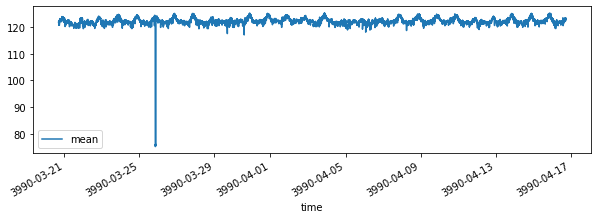

In [12]:
df.plot(x='time', y='mean', figsize=(10,3))

# Finding an event

In [13]:
min_time = df['mean'].idxmin()
df['time'].loc[min_time]

Timestamp('2021-03-24 20:52:41.864110+0000', tz='UTC')

In [14]:
# Choose a 5-hour window to share that includes data leading up to and after the event
start_share = datetime(2021, 3, 24, 18)
end_share = datetime(2021, 3, 24, 23)

# Data anonymization

## Examining metadata

In [15]:
print('Sensor Metadata\n===============')
voltage.annotations()


Sensor Metadata


({'STN': 'Laurel_UPMU',
  'longitude': -122.211962,
  'ID_1': 0,
  'hardware': 'microPMU',
  'latitude': 37.842514,
  'location': 'Oakland, CA',
  'nominal_volts': 120,
  'sample_rate': '60Hz',
  'interconnect': 'WECC',
  'original_uuid': 'cf0462cf-1c19-595b-96e4-169edc4a7448',
  'ID_2': 0,
  'siting': 'wall outlet'},
 7)

## Modify metadata to remove sensitive information

In [16]:
raw_metadata, _ = voltage.annotations()
anon_metadata = {}

share_fields = ['siting','hardware','interconnect','location','sample_rate',]
for field in share_fields:
    anon_metadata[field] = str(raw_metadata[field])

if 'latitude' in anon_metadata.keys():
    del anon_metadata['latitude']

if 'longitude' in anon_metadata.keys():
    del anon_metadata['longitude']

anon_metadata['station'] = 'pmu0001'


print('Updated Metadata\n===============')    
anon_metadata

Updated Metadata


{'siting': 'wall outlet',
 'hardware': 'microPMU',
 'interconnect': 'WECC',
 'location': 'Oakland, CA',
 'sample_rate': '60Hz',
 'station': 'pmu0001'}

In [17]:
for s in db.streams_in_collection('anonymized/oakland'):
    s.obliterate()

# Create an anonymized stream

In [18]:
import uuid

new_stream = db.create(uuid=uuid.uuid4(),
                       tags={'name': 'Vmag', 'unit': 'p.u.'},
                       annotations=anon_metadata,
                       collection='anonymized/oakland')

## Check that metadata is changed

In [19]:
new_stream.annotations()

({'siting': 'wall outlet',
  'hardware': 'microPMU',
  'interconnect': 'WECC',
  'location': 'Oakland, CA',
  'sample_rate': '60Hz',
  'station': 'pmu0001'},
 0)

## Pull raw data from original data stream

In [20]:
%%time

# get data from database
points, _ = zip(*voltage.values(datetime_to_ns(start_share), datetime_to_ns(end_share)))

CPU times: user 4.46 s, sys: 320 ms, total: 4.78 s
Wall time: 5.32 s


## Perform transformations

Here we'll convert to p.u. voltage.

In [21]:
%%time
def convert_to_pu(values, base=raw_metadata['nominal_volts']):
    return [v/base for v in values]

def do_nothing(values):
    return values

times, values = zip(*[(v.time, v.value) for v in points])
pu_values = convert_to_pu(values)

CPU times: user 1.3 s, sys: 98.4 ms, total: 1.4 s
Wall time: 1.94 s


## Insert transformed values into the new anonymized stream

In [22]:
%%time
new_stream.insert(list(zip(times, pu_values)))

CPU times: user 5.8 s, sys: 312 ms, total: 6.11 s
Wall time: 20.9 s


30